<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugmentAt50Percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [57]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models

import tensorflow as tf
from tqdm import tqdm

In [59]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Fetching Data

In [60]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

fatal: destination path 'Volve-Well-Log-Prediction' already exists and is not an empty directory.


In [61]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [62]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [63]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


## Dropping Data

In [64]:
num_rows_to_drop = int(0.5 * len(train))

# Randomly sample rows to drop
rows_to_drop = train.sample(n=num_rows_to_drop)

# Drop the sampled rows from the DataFrame
train = train.drop(rows_to_drop.index)
train_preserve = train.copy()

In [65]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [66]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.519175,-0.848053,1.152409,-0.587655,-0.233855,-0.0,1.503613,15_9-F-11A,2600.1
1,1.333845,-0.973097,1.088298,-0.608319,-0.664368,-0.0,1.462887,15_9-F-11A,2600.2
2,1.167632,-1.335892,0.519263,-0.507172,-1.220038,-0.0,1.056418,15_9-F-11A,2600.7
3,1.303354,-1.263767,0.524582,-0.690518,-0.877682,-0.0,1.000025,15_9-F-11A,2600.9
4,1.415735,-1.214693,0.555802,-0.773834,-0.69464,-0.0,1.055461,15_9-F-11A,2601.0


## Outlier Removal

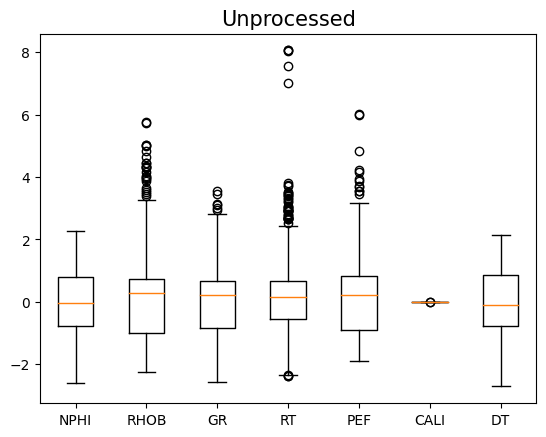

n samples unprocessed: 5237


In [67]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

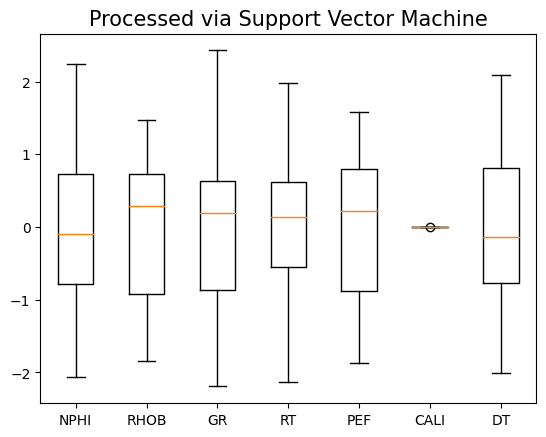

Remaining samples: 4710


In [68]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [69]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [70]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [71]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

## Data Augmentation

In [72]:
# Select columns for features (X) and target (y)
train_total = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')
train_gen = train_svm.copy()

In [73]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_total[train_total['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_total[train_total['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_total[train_total['WELL'] == '15_9-F-1B'].copy()

In [74]:
# # Fit and transform the 'DEPTH' column for df_gen1
# df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen3
# df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen4
# df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [75]:
df_gen1.drop(columns = 'WELL').astype('float32').describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2.418000e+03,2418.000000,2418.000000
mean,0.020878,-0.096919,-0.128279,-0.013033,0.144823,3.018333e-17,0.041714,3114.783691
std,0.998615,0.956748,0.940370,0.923892,1.021612,8.874725e-17,1.042392,356.095337
min,-1.836181,-1.844921,-2.183082,-2.134081,-1.682039,-2.636780e-16,-2.003131,2600.100098
25%,-0.839134,-1.208502,-0.935719,-0.468226,-0.902275,-2.775558e-17,-0.837915,2798.925049
50%,-0.068158,0.252000,0.096458,0.201377,0.511992,2.775558e-17,-0.096731,3062.500000
75%,0.837765,0.712696,0.555578,0.678175,1.100754,1.110223e-16,0.904615,3462.474976
max,2.105063,1.370760,2.287340,1.982535,1.586926,3.053113e-16,2.055941,3719.899902


In [76]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model


In [77]:
generator_loss_fn =  tf.keras.losses.BinaryFocalCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryFocalCrossentropy()


In [78]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.uniform(-1, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [79]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.uniform(-1, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [80]:
# Train the GAN
# Define GAN components

latent_dim = 128

num_features = len(train_gen.columns)

generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

epochs = 64
batch_size = 4096
num_batches = len(train_gen) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, train_gen, generator_optimizer, discriminator_optimizer)

Epoch 1/64: 100%|██████████| 1/1 [00:02<00:00,  2.97s/batch]


Epoch 1/64, Discriminator Loss: 0.8352837562561035, Generator Loss: 0.42189010977745056


Epoch 2/64: 100%|██████████| 1/1 [00:02<00:00,  2.67s/batch]


Epoch 2/64, Discriminator Loss: 0.8266683220863342, Generator Loss: 0.4046447277069092


Epoch 3/64: 100%|██████████| 1/1 [00:01<00:00,  1.52s/batch]


Epoch 3/64, Discriminator Loss: 0.8145031929016113, Generator Loss: 0.3884536027908325


Epoch 4/64: 100%|██████████| 1/1 [00:02<00:00,  2.22s/batch]


Epoch 4/64, Discriminator Loss: 0.7962480783462524, Generator Loss: 0.3856714367866516


Epoch 5/64: 100%|██████████| 1/1 [00:02<00:00,  2.25s/batch]


Epoch 5/64, Discriminator Loss: 0.7850760221481323, Generator Loss: 0.36839228868484497


Epoch 6/64: 100%|██████████| 1/1 [00:02<00:00,  2.70s/batch]


Epoch 6/64, Discriminator Loss: 0.7787752747535706, Generator Loss: 0.36266565322875977


Epoch 7/64: 100%|██████████| 1/1 [00:02<00:00,  2.09s/batch]


Epoch 7/64, Discriminator Loss: 0.7660430073738098, Generator Loss: 0.35134971141815186


Epoch 8/64: 100%|██████████| 1/1 [00:03<00:00,  3.38s/batch]


Epoch 8/64, Discriminator Loss: 0.7567306756973267, Generator Loss: 0.34350505471229553


Epoch 9/64: 100%|██████████| 1/1 [00:02<00:00,  2.40s/batch]


Epoch 9/64, Discriminator Loss: 0.742592453956604, Generator Loss: 0.33727964758872986


Epoch 10/64: 100%|██████████| 1/1 [00:02<00:00,  2.10s/batch]


Epoch 10/64, Discriminator Loss: 0.7318154573440552, Generator Loss: 0.3317064046859741


Epoch 11/64: 100%|██████████| 1/1 [00:02<00:00,  2.24s/batch]


Epoch 11/64, Discriminator Loss: 0.7165573239326477, Generator Loss: 0.3245220184326172


Epoch 12/64: 100%|██████████| 1/1 [00:02<00:00,  2.33s/batch]


Epoch 12/64, Discriminator Loss: 0.7025922536849976, Generator Loss: 0.31931960582733154


Epoch 13/64: 100%|██████████| 1/1 [00:03<00:00,  3.54s/batch]


Epoch 13/64, Discriminator Loss: 0.690178632736206, Generator Loss: 0.3153780400753021


Epoch 14/64: 100%|██████████| 1/1 [00:02<00:00,  2.30s/batch]


Epoch 14/64, Discriminator Loss: 0.6789064407348633, Generator Loss: 0.31242531538009644


Epoch 15/64: 100%|██████████| 1/1 [00:02<00:00,  2.51s/batch]


Epoch 15/64, Discriminator Loss: 0.6710147261619568, Generator Loss: 0.30815771222114563


Epoch 16/64: 100%|██████████| 1/1 [00:03<00:00,  3.10s/batch]


Epoch 16/64, Discriminator Loss: 0.6616089344024658, Generator Loss: 0.300933837890625


Epoch 17/64: 100%|██████████| 1/1 [00:04<00:00,  4.21s/batch]


Epoch 17/64, Discriminator Loss: 0.6532847285270691, Generator Loss: 0.2987982928752899


Epoch 18/64: 100%|██████████| 1/1 [00:03<00:00,  3.52s/batch]


Epoch 18/64, Discriminator Loss: 0.6411325335502625, Generator Loss: 0.2940490245819092


Epoch 19/64: 100%|██████████| 1/1 [00:02<00:00,  2.71s/batch]


Epoch 19/64, Discriminator Loss: 0.6390658617019653, Generator Loss: 0.29024583101272583


Epoch 20/64: 100%|██████████| 1/1 [00:02<00:00,  2.32s/batch]


Epoch 20/64, Discriminator Loss: 0.6264146566390991, Generator Loss: 0.2901831567287445


Epoch 21/64: 100%|██████████| 1/1 [00:02<00:00,  2.07s/batch]


Epoch 21/64, Discriminator Loss: 0.6143572926521301, Generator Loss: 0.2843775451183319


Epoch 22/64: 100%|██████████| 1/1 [00:02<00:00,  2.63s/batch]


Epoch 22/64, Discriminator Loss: 0.6067149043083191, Generator Loss: 0.2849521040916443


Epoch 23/64: 100%|██████████| 1/1 [00:02<00:00,  2.55s/batch]


Epoch 23/64, Discriminator Loss: 0.6001699566841125, Generator Loss: 0.27876317501068115


Epoch 24/64: 100%|██████████| 1/1 [00:02<00:00,  2.12s/batch]


Epoch 24/64, Discriminator Loss: 0.5885117053985596, Generator Loss: 0.2732355296611786


Epoch 25/64: 100%|██████████| 1/1 [00:02<00:00,  2.08s/batch]


Epoch 25/64, Discriminator Loss: 0.5858243703842163, Generator Loss: 0.27329301834106445


Epoch 26/64: 100%|██████████| 1/1 [00:02<00:00,  2.29s/batch]


Epoch 26/64, Discriminator Loss: 0.5760595202445984, Generator Loss: 0.272045761346817


Epoch 27/64: 100%|██████████| 1/1 [00:02<00:00,  2.69s/batch]


Epoch 27/64, Discriminator Loss: 0.5747328996658325, Generator Loss: 0.27110224962234497


Epoch 28/64: 100%|██████████| 1/1 [00:01<00:00,  1.54s/batch]


Epoch 28/64, Discriminator Loss: 0.5614945888519287, Generator Loss: 0.2668084502220154


Epoch 29/64: 100%|██████████| 1/1 [00:01<00:00,  1.30s/batch]


Epoch 29/64, Discriminator Loss: 0.5598117709159851, Generator Loss: 0.265217125415802


Epoch 30/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]


Epoch 30/64, Discriminator Loss: 0.5543540120124817, Generator Loss: 0.2632597088813782


Epoch 31/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]


Epoch 31/64, Discriminator Loss: 0.5495743155479431, Generator Loss: 0.26212650537490845


Epoch 32/64: 100%|██████████| 1/1 [00:01<00:00,  1.14s/batch]


Epoch 32/64, Discriminator Loss: 0.5472527742385864, Generator Loss: 0.2629588544368744


Epoch 33/64: 100%|██████████| 1/1 [00:01<00:00,  1.11s/batch]


Epoch 33/64, Discriminator Loss: 0.5364594459533691, Generator Loss: 0.26108017563819885


Epoch 34/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]


Epoch 34/64, Discriminator Loss: 0.536537766456604, Generator Loss: 0.2591418921947479


Epoch 35/64: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch]


Epoch 35/64, Discriminator Loss: 0.5289241075515747, Generator Loss: 0.2563195824623108


Epoch 36/64: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch]


Epoch 36/64, Discriminator Loss: 0.5254707932472229, Generator Loss: 0.25371861457824707


Epoch 37/64: 100%|██████████| 1/1 [00:01<00:00,  1.10s/batch]


Epoch 37/64, Discriminator Loss: 0.5245554447174072, Generator Loss: 0.25271451473236084


Epoch 38/64: 100%|██████████| 1/1 [00:01<00:00,  1.48s/batch]


Epoch 38/64, Discriminator Loss: 0.5241169333457947, Generator Loss: 0.25237327814102173


Epoch 39/64: 100%|██████████| 1/1 [00:01<00:00,  1.57s/batch]


Epoch 39/64, Discriminator Loss: 0.5168329477310181, Generator Loss: 0.2505375146865845


Epoch 40/64: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch]


Epoch 40/64, Discriminator Loss: 0.5155068635940552, Generator Loss: 0.24769243597984314


Epoch 41/64: 100%|██████████| 1/1 [00:01<00:00,  1.07s/batch]


Epoch 41/64, Discriminator Loss: 0.5095742344856262, Generator Loss: 0.24971051514148712


Epoch 42/64: 100%|██████████| 1/1 [00:01<00:00,  1.11s/batch]


Epoch 42/64, Discriminator Loss: 0.5092294216156006, Generator Loss: 0.2489723116159439


Epoch 43/64: 100%|██████████| 1/1 [00:01<00:00,  1.18s/batch]


Epoch 43/64, Discriminator Loss: 0.5048418045043945, Generator Loss: 0.2457561194896698


Epoch 44/64: 100%|██████████| 1/1 [00:01<00:00,  1.10s/batch]


Epoch 44/64, Discriminator Loss: 0.5017586946487427, Generator Loss: 0.2465624213218689


Epoch 45/64: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch]


Epoch 45/64, Discriminator Loss: 0.5009781122207642, Generator Loss: 0.24171122908592224


Epoch 46/64: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch]


Epoch 46/64, Discriminator Loss: 0.5002375841140747, Generator Loss: 0.24408040940761566


Epoch 47/64: 100%|██████████| 1/1 [00:01<00:00,  1.81s/batch]


Epoch 47/64, Discriminator Loss: 0.4990890622138977, Generator Loss: 0.2412794530391693


Epoch 48/64: 100%|██████████| 1/1 [00:01<00:00,  1.77s/batch]


Epoch 48/64, Discriminator Loss: 0.4943541884422302, Generator Loss: 0.2406984269618988


Epoch 49/64: 100%|██████████| 1/1 [00:01<00:00,  1.36s/batch]


Epoch 49/64, Discriminator Loss: 0.4929988384246826, Generator Loss: 0.24025261402130127


Epoch 50/64: 100%|██████████| 1/1 [00:01<00:00,  1.11s/batch]


Epoch 50/64, Discriminator Loss: 0.4927619993686676, Generator Loss: 0.24130401015281677


Epoch 51/64: 100%|██████████| 1/1 [00:01<00:00,  1.14s/batch]


Epoch 51/64, Discriminator Loss: 0.4927654266357422, Generator Loss: 0.2415865659713745


Epoch 52/64: 100%|██████████| 1/1 [00:01<00:00,  1.77s/batch]


Epoch 52/64, Discriminator Loss: 0.48799148201942444, Generator Loss: 0.23821775615215302


Epoch 53/64: 100%|██████████| 1/1 [00:01<00:00,  1.49s/batch]


Epoch 53/64, Discriminator Loss: 0.484302818775177, Generator Loss: 0.23744219541549683


Epoch 54/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]


Epoch 54/64, Discriminator Loss: 0.4847356081008911, Generator Loss: 0.237799271941185


Epoch 55/64: 100%|██████████| 1/1 [00:01<00:00,  1.14s/batch]


Epoch 55/64, Discriminator Loss: 0.4837145507335663, Generator Loss: 0.23753371834754944


Epoch 56/64: 100%|██████████| 1/1 [00:01<00:00,  1.12s/batch]


Epoch 56/64, Discriminator Loss: 0.48162394762039185, Generator Loss: 0.23633064329624176


Epoch 57/64: 100%|██████████| 1/1 [00:01<00:00,  1.42s/batch]


Epoch 57/64, Discriminator Loss: 0.48123636841773987, Generator Loss: 0.2386334240436554


Epoch 58/64: 100%|██████████| 1/1 [00:01<00:00,  1.79s/batch]


Epoch 58/64, Discriminator Loss: 0.4780588150024414, Generator Loss: 0.23610135912895203


Epoch 59/64: 100%|██████████| 1/1 [00:01<00:00,  1.15s/batch]


Epoch 59/64, Discriminator Loss: 0.4794749617576599, Generator Loss: 0.23468956351280212


Epoch 60/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]


Epoch 60/64, Discriminator Loss: 0.4729871153831482, Generator Loss: 0.23412351310253143


Epoch 61/64: 100%|██████████| 1/1 [00:01<00:00,  1.07s/batch]


Epoch 61/64, Discriminator Loss: 0.4754740595817566, Generator Loss: 0.2351183295249939


Epoch 62/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]


Epoch 62/64, Discriminator Loss: 0.4738391935825348, Generator Loss: 0.23263397812843323


Epoch 63/64: 100%|██████████| 1/1 [00:01<00:00,  1.15s/batch]


Epoch 63/64, Discriminator Loss: 0.4750640392303467, Generator Loss: 0.23361116647720337


Epoch 64/64: 100%|██████████| 1/1 [00:01<00:00,  1.13s/batch]

Epoch 64/64, Discriminator Loss: 0.47134408354759216, Generator Loss: 0.23328304290771484


In [81]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(df_gen1)*0.25))

19/19 [==============================] - 0s 2ms/step


In [82]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_1, int(len(df_gen1)*0.25))

19/19 [==============================] - 0s 2ms/step


In [83]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_1, int(len(df_gen1)*0.25))

19/19 [==============================] - 0s 2ms/step


In [84]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [85]:
from sklearn.ensemble import GradientBoostingRegressor
boosters = {}

# Train gradient boosters for each well
for well_name, df_gen in zip(train_well_names, [df_gen1, df_gen3, df_gen4]):
    # Filter data for the current well
    # df_gen = train_total[train_total['WELL'] == well_name].copy()

    # Define features (X) and target (y)
    X = df_gen.drop(columns=['DEPTH', 'WELL'])  # Assuming 'DEPTH' and 'WELL' are not features
    y = df_gen['DEPTH']

    # Train gradient booster
    booster = GradientBoostingRegressor()
    booster.fit(X, y)

    # Store trained booster in the dictionary
    boosters[well_name] = booster

# Use trained boosters to predict 'DEPTH' values for synthetic data frames
for synthetic_df, well_name in zip([synthetic_df_1, synthetic_df_3, synthetic_df_4], train_well_names):
    # Get corresponding booster for the well
    booster = boosters[well_name]

    # Predict 'DEPTH' values for synthetic data
    synthetic_df['DEPTH'] = booster.predict(synthetic_df)

In [86]:
# scaler.fit(train_total[train_total['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
# df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
# synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
# df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
# synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
# df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
# synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [87]:
def exponential_smoothing(series, alpha):
    smoothed_series = series.copy()
    for i in range(1, len(series)):
        smoothed_series[i] = alpha * series[i] + (1 - alpha) * smoothed_series[i - 1]
    return smoothed_series


In [88]:
# # Define alpha for exponential smoothing (adjust as needed)
# alpha = 0.2

# # Apply sorting and exponential smoothing for each DataFrame
# for synthetic_df in [synthetic_df_1, synthetic_df_3, synthetic_df_4]:
#     synthetic_df.sort_values(by='DEPTH', inplace=True)
#     for column in synthetic_df.columns:
#         if column != 'WELL':  # Skip the 'WELL' column
#             synthetic_df[column] = exponential_smoothing(synthetic_df[column], alpha)

In [89]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

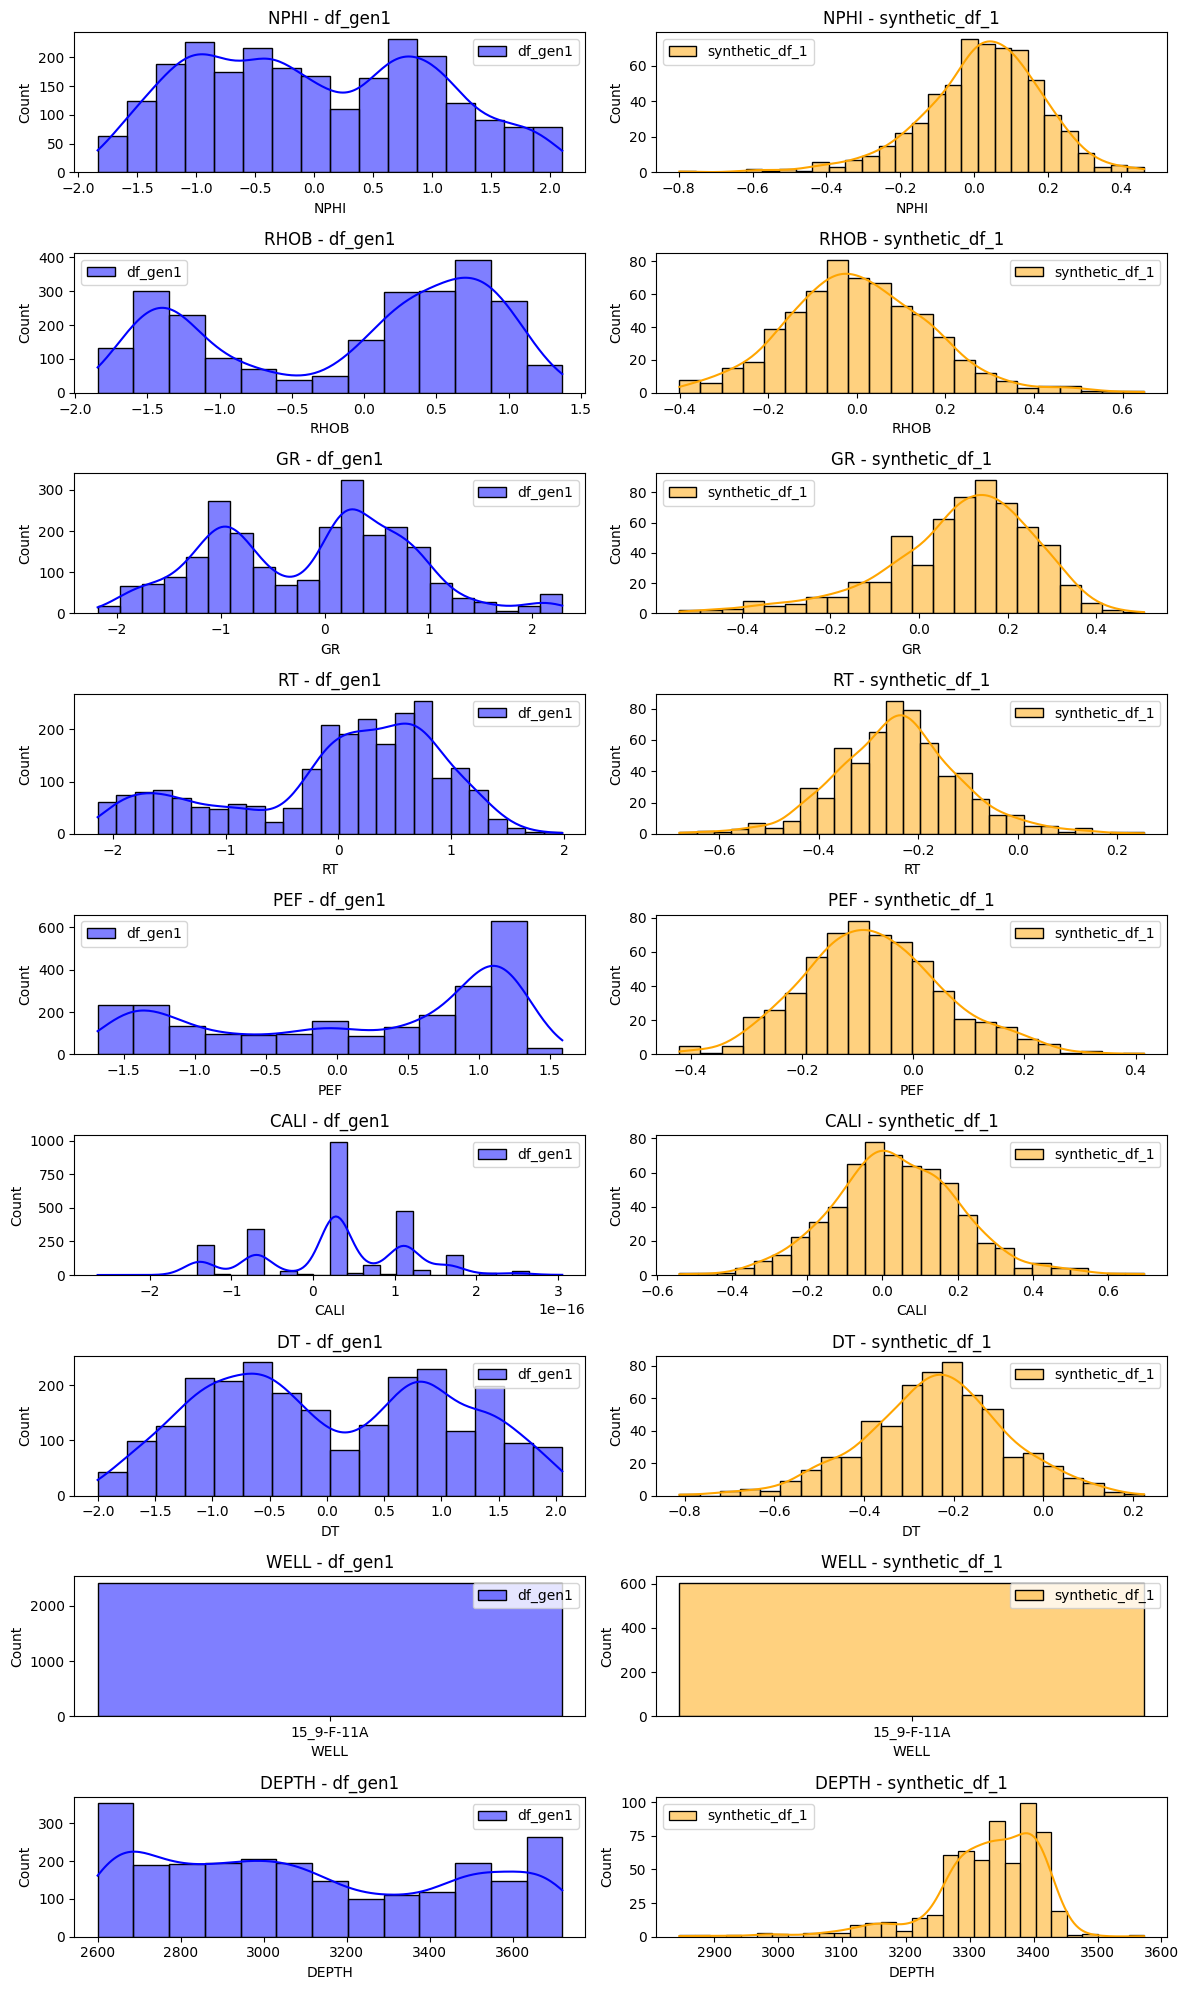

In [90]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

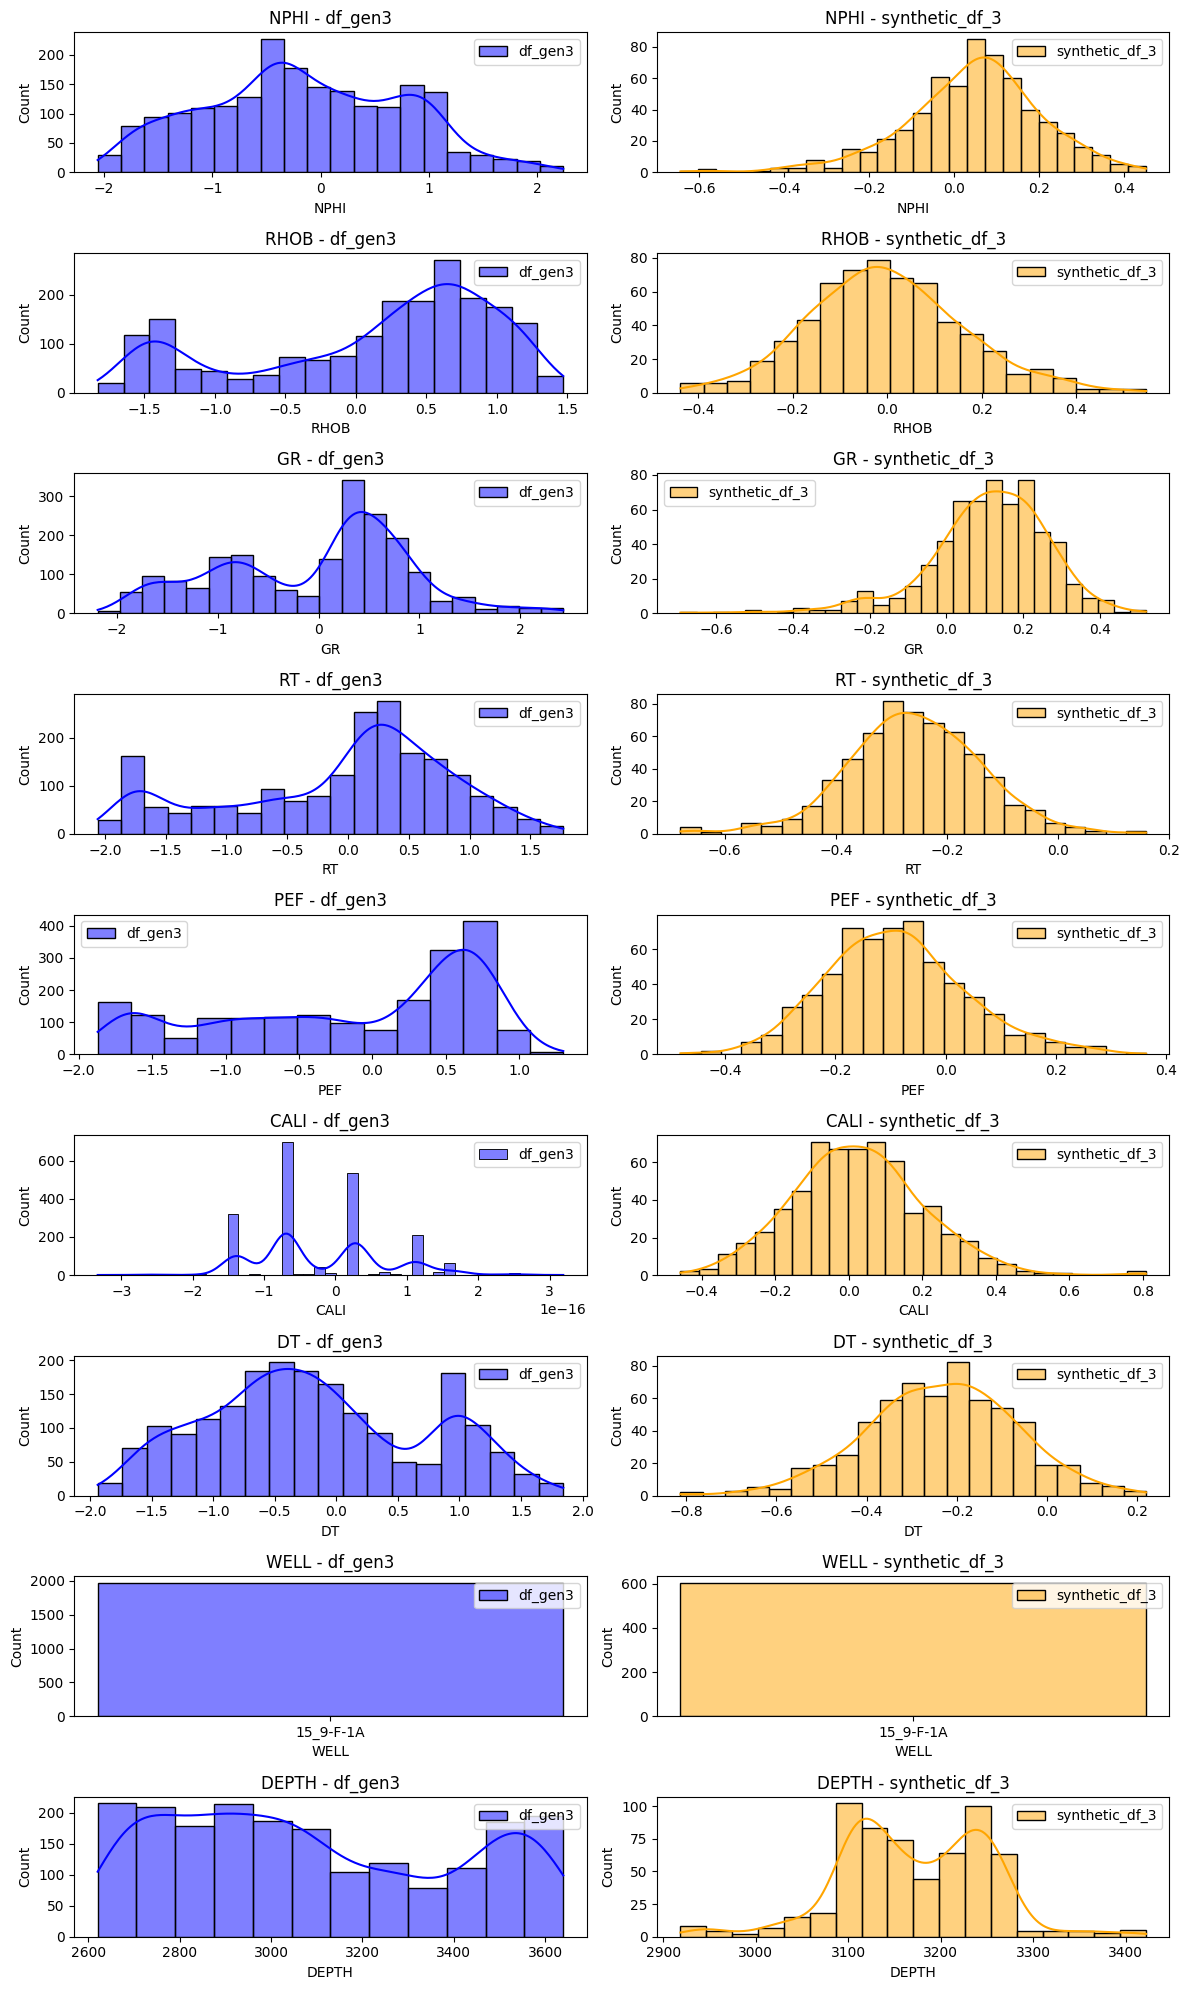

In [91]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

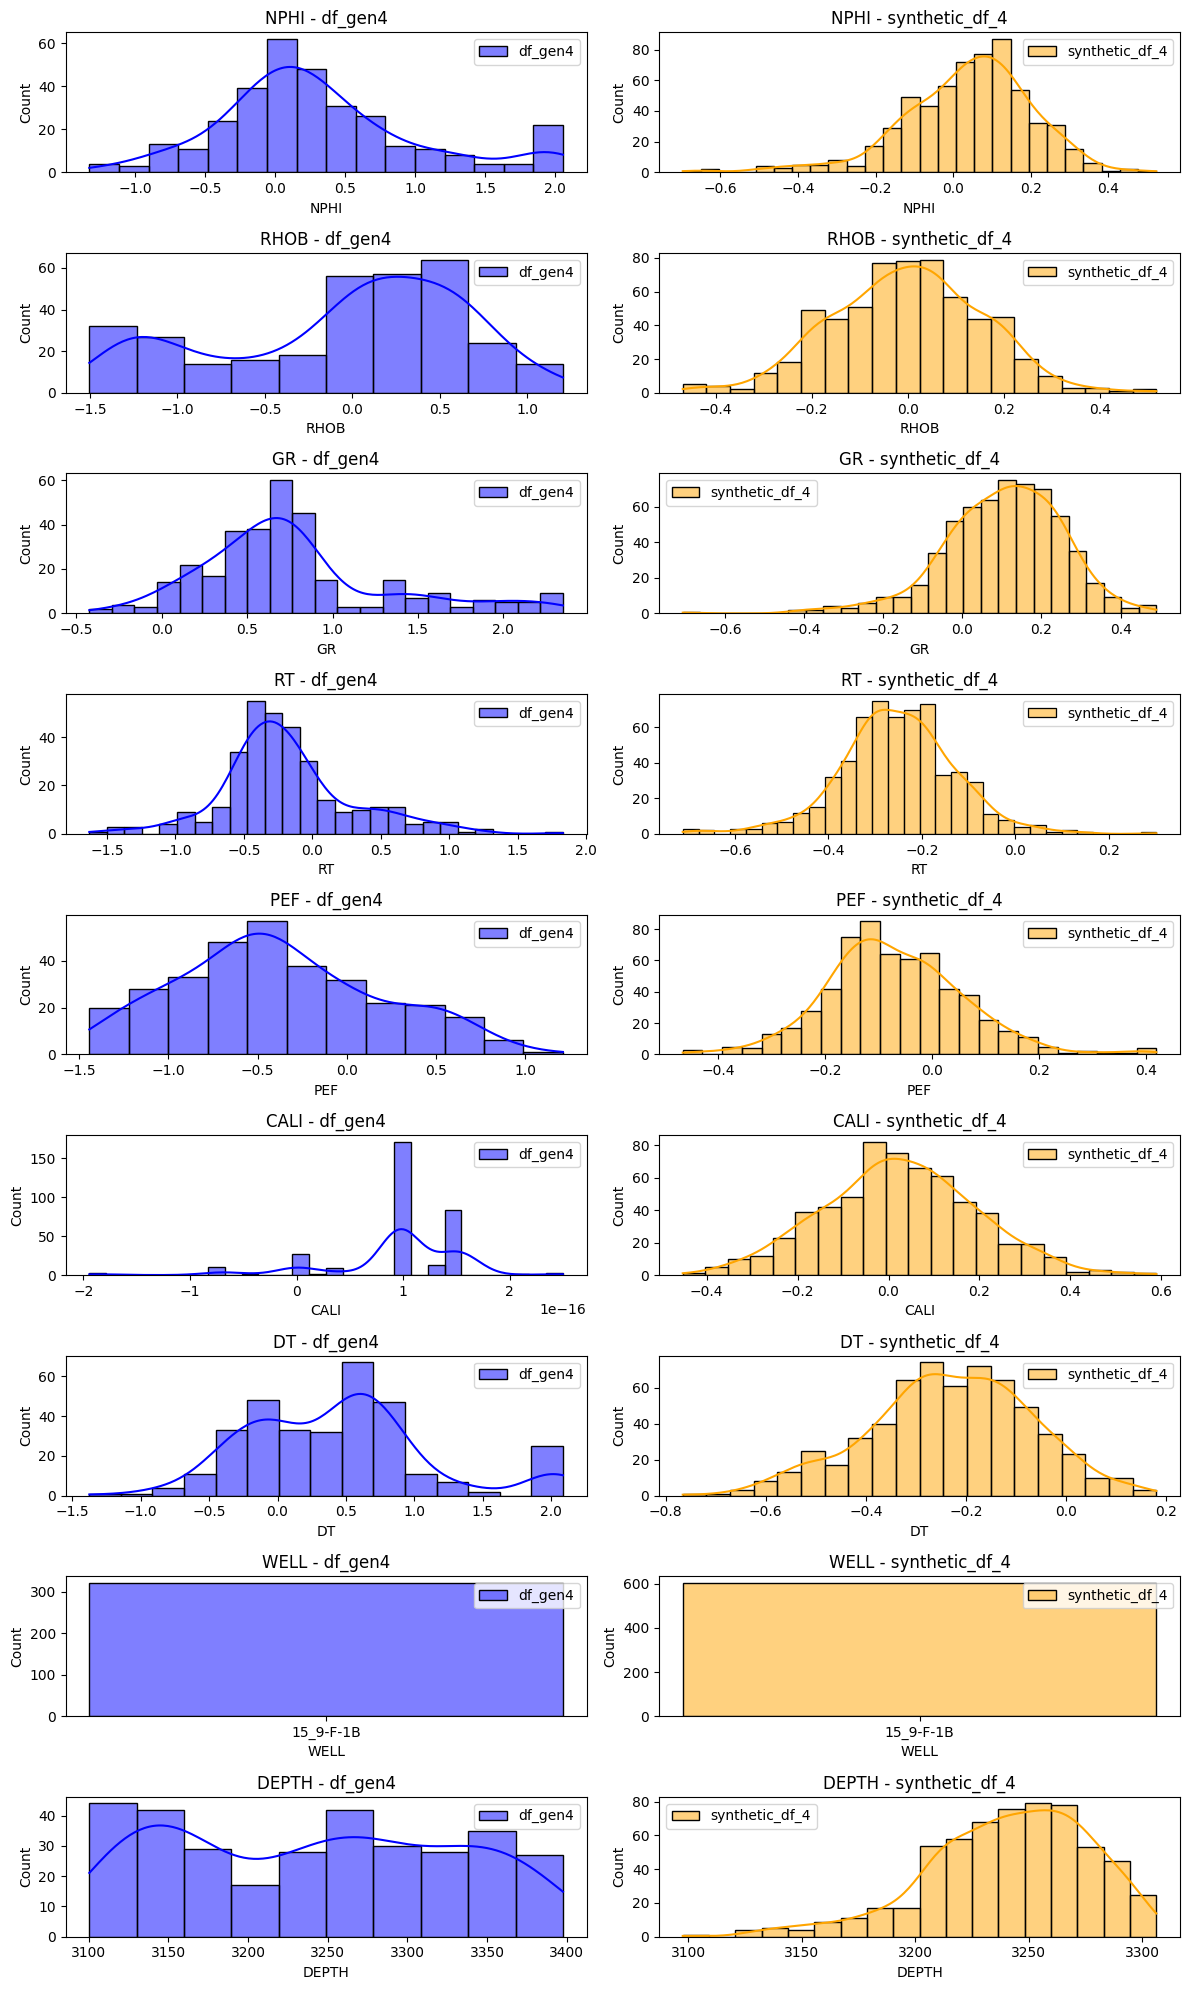

In [92]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [93]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')


In [94]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [95]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

# Fit the regressor to the training data
model_decision_tree.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


R2 Log 1: 0.9712
RMSE Log 1: 0.1835
R2 Log 3: 0.8077
RMSE Log 3: 0.3967
R2 Log 4: 0.7106
RMSE Log 4: 0.3766


### Gradient Booster Regressor

In [96]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

# Fit the regressor to the training data
model_grad_boost.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Log 1: 0.956
RMSE Log 1: 0.2266
R2 Log 3: 0.892
RMSE Log 3: 0.2973
R2 Log 4: 0.8399
RMSE Log 4: 0.2801


### Neural Network

In [97]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Fit the neural network model to the training data
history_nn = model_nn.fit(X_train_new, y_train_new, epochs=16, batch_size=1024, validation_data=(X_val1, y_val1))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


Epoch 1/16
11/11 [==============================] - 1s 21ms/step - loss: 0.6517 - val_loss: 0.4457
Epoch 2/16
11/11 [==============================] - 0s 8ms/step - loss: 0.1986 - val_loss: 0.1076
Epoch 3/16
11/11 [==============================] - 0s 8ms/step - loss: 0.1078 - val_loss: 0.0779
Epoch 4/16
11/11 [==============================] - 0s 8ms/step - loss: 0.0676 - val_loss: 0.0775
Epoch 5/16
11/11 [==============================] - 0s 9ms/step - loss: 0.0550 - val_loss: 0.0714
Epoch 6/16
11/11 [==============================] - 0s 9ms/step - loss: 0.0493 - val_loss: 0.0679
Epoch 7/16
11/11 [==============================] - 0s 7ms/step - loss: 0.0464 - val_loss: 0.0665
Epoch 8/16
11/11 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.0667
Epoch 9/16
11/11 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.0666
Epoch 10/16
11/11 [==============================] - 0s 8ms/step - loss: 0.0416 - val_loss: 0.0651
Epoch 11/16
11/11 

### LSTM

In [98]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [99]:
y_train_lstm.shape

(10264, 1)

In [100]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the LSTM model to the training data
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=16, batch_size=1024, validation_data=(X_val1_lstm, y_val1_lstm))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


Epoch 1/16
11/11 [==============================] - 22s 996ms/step - loss: 0.2949 - val_loss: 0.2075
Epoch 2/16
11/11 [==============================] - 6s 535ms/step - loss: 0.1729 - val_loss: 0.1960
Epoch 3/16
11/11 [==============================] - 5s 463ms/step - loss: 0.1483 - val_loss: 0.1608
Epoch 4/16
11/11 [==============================] - 5s 446ms/step - loss: 0.1375 - val_loss: 0.1592
Epoch 5/16
11/11 [==============================] - 6s 561ms/step - loss: 0.1361 - val_loss: 0.1548
Epoch 6/16
11/11 [==============================] - 5s 444ms/step - loss: 0.1268 - val_loss: 0.1466
Epoch 7/16
11/11 [==============================] - 6s 566ms/step - loss: 0.1242 - val_loss: 0.1343
Epoch 8/16
11/11 [==============================] - 5s 447ms/step - loss: 0.1205 - val_loss: 0.1360
Epoch 9/16
11/11 [==============================] - 5s 462ms/step - loss: 0.1175 - val_loss: 0.1302
Epoch 10/16
11/11 [==============================] - 10s 932ms/step - loss: 0.1154 - val_loss: 0.13

### Formatting back the predictions

In [101]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

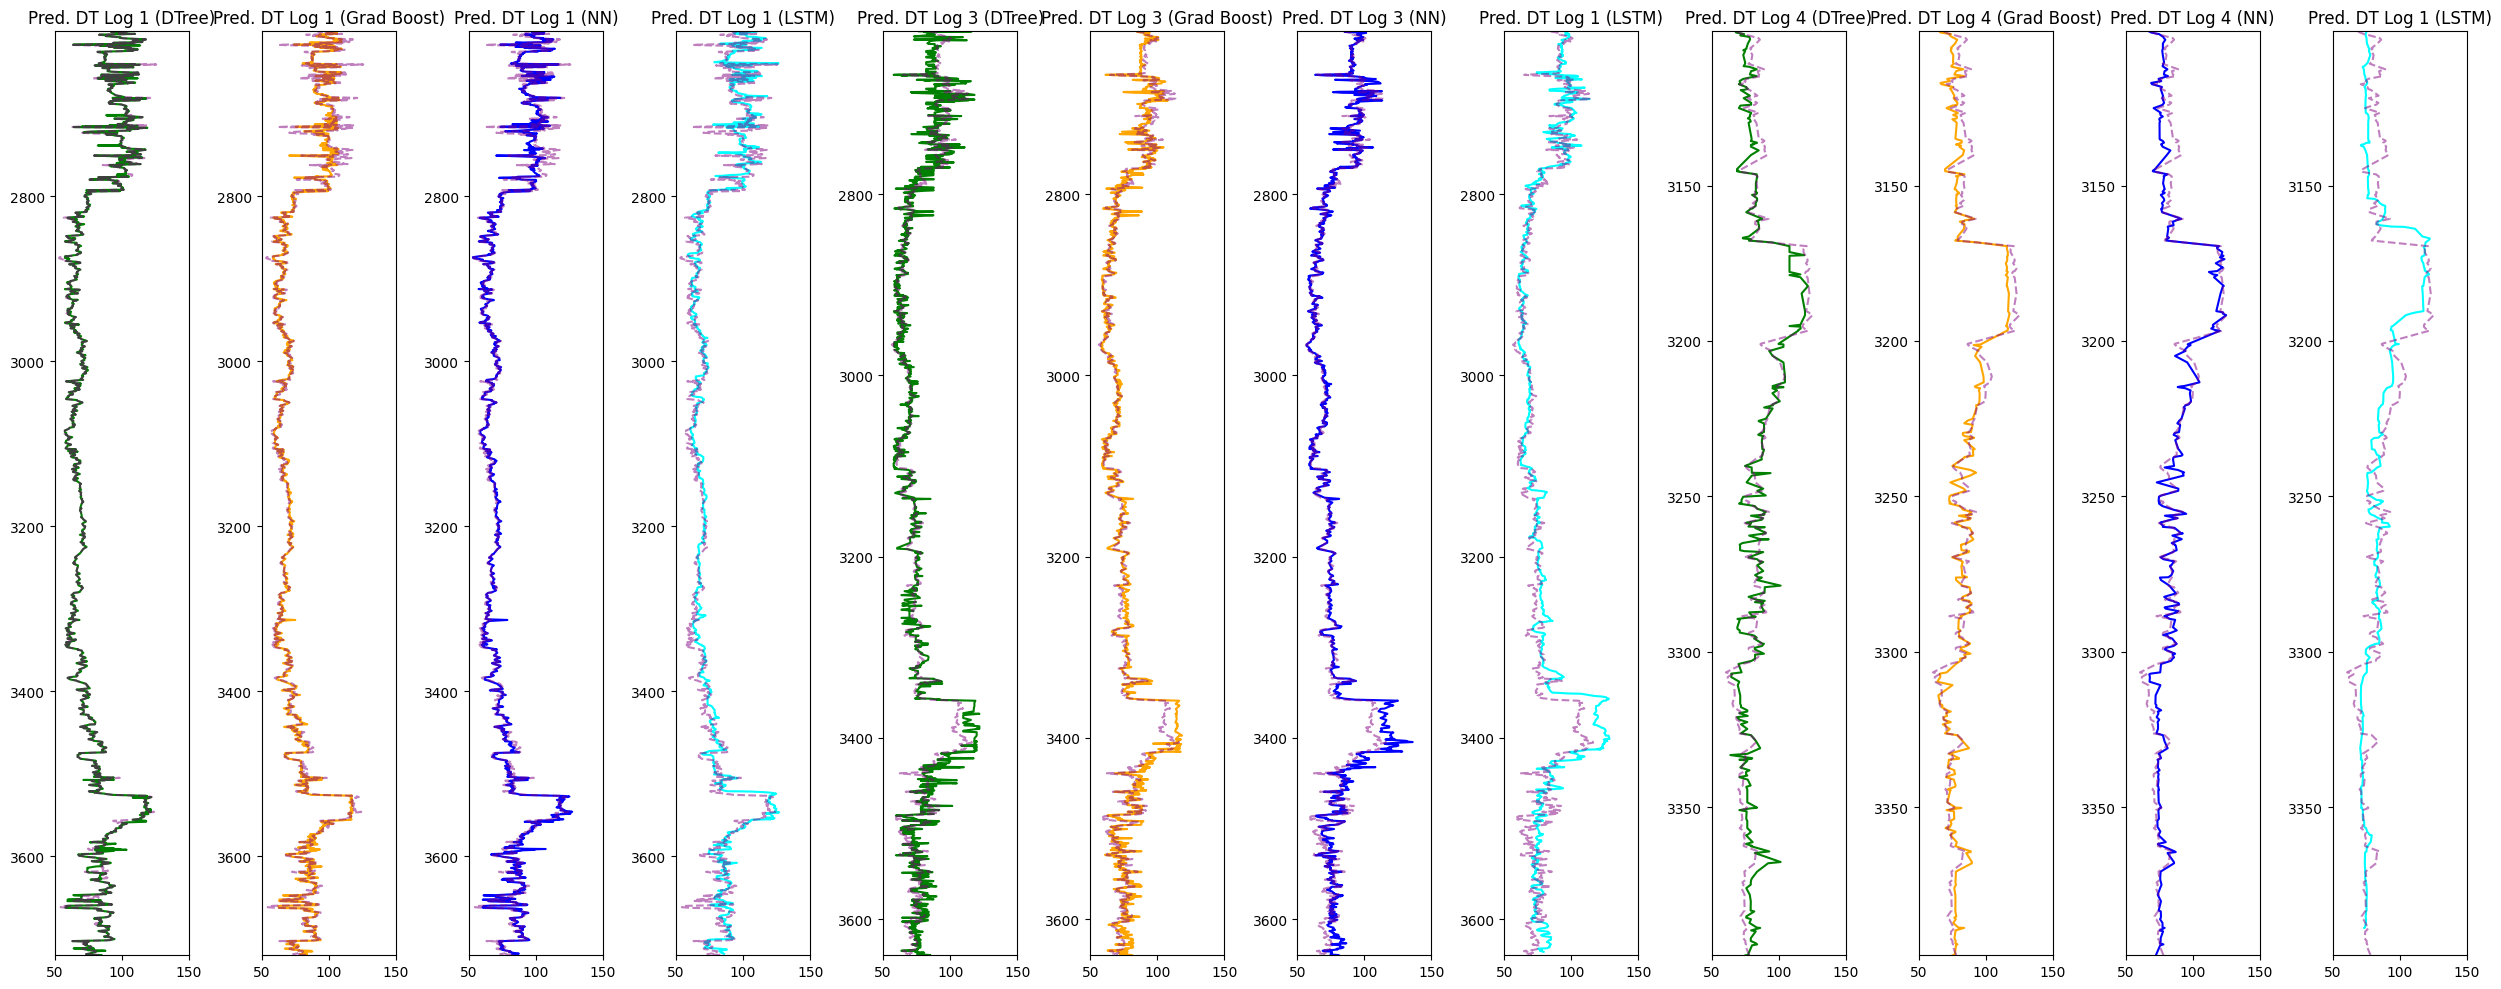

In [102]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott =  [train_preserve[train_preserve['WELL'] == '15_9-F-11A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1B']['DEPTH']]

#  [log1['DEPTH'],
#            log3['DEPTH'],
#            log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [103]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [104]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [105]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 7s 23ms/step


In [106]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [107]:
y_pred2_lstm

array([[61.89077 ],
       [61.959682],
       [62.052456],
       ...,
       [67.58072 ],
       [67.57291 ],
       [67.60415 ]], dtype=float32)

In [108]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[62.14871399],
       [62.13152931],
       [62.12434082],
       ...,
       [67.58071899],
       [67.57290649],
       [67.60414886]])

In [109]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-109-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-109-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-109-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

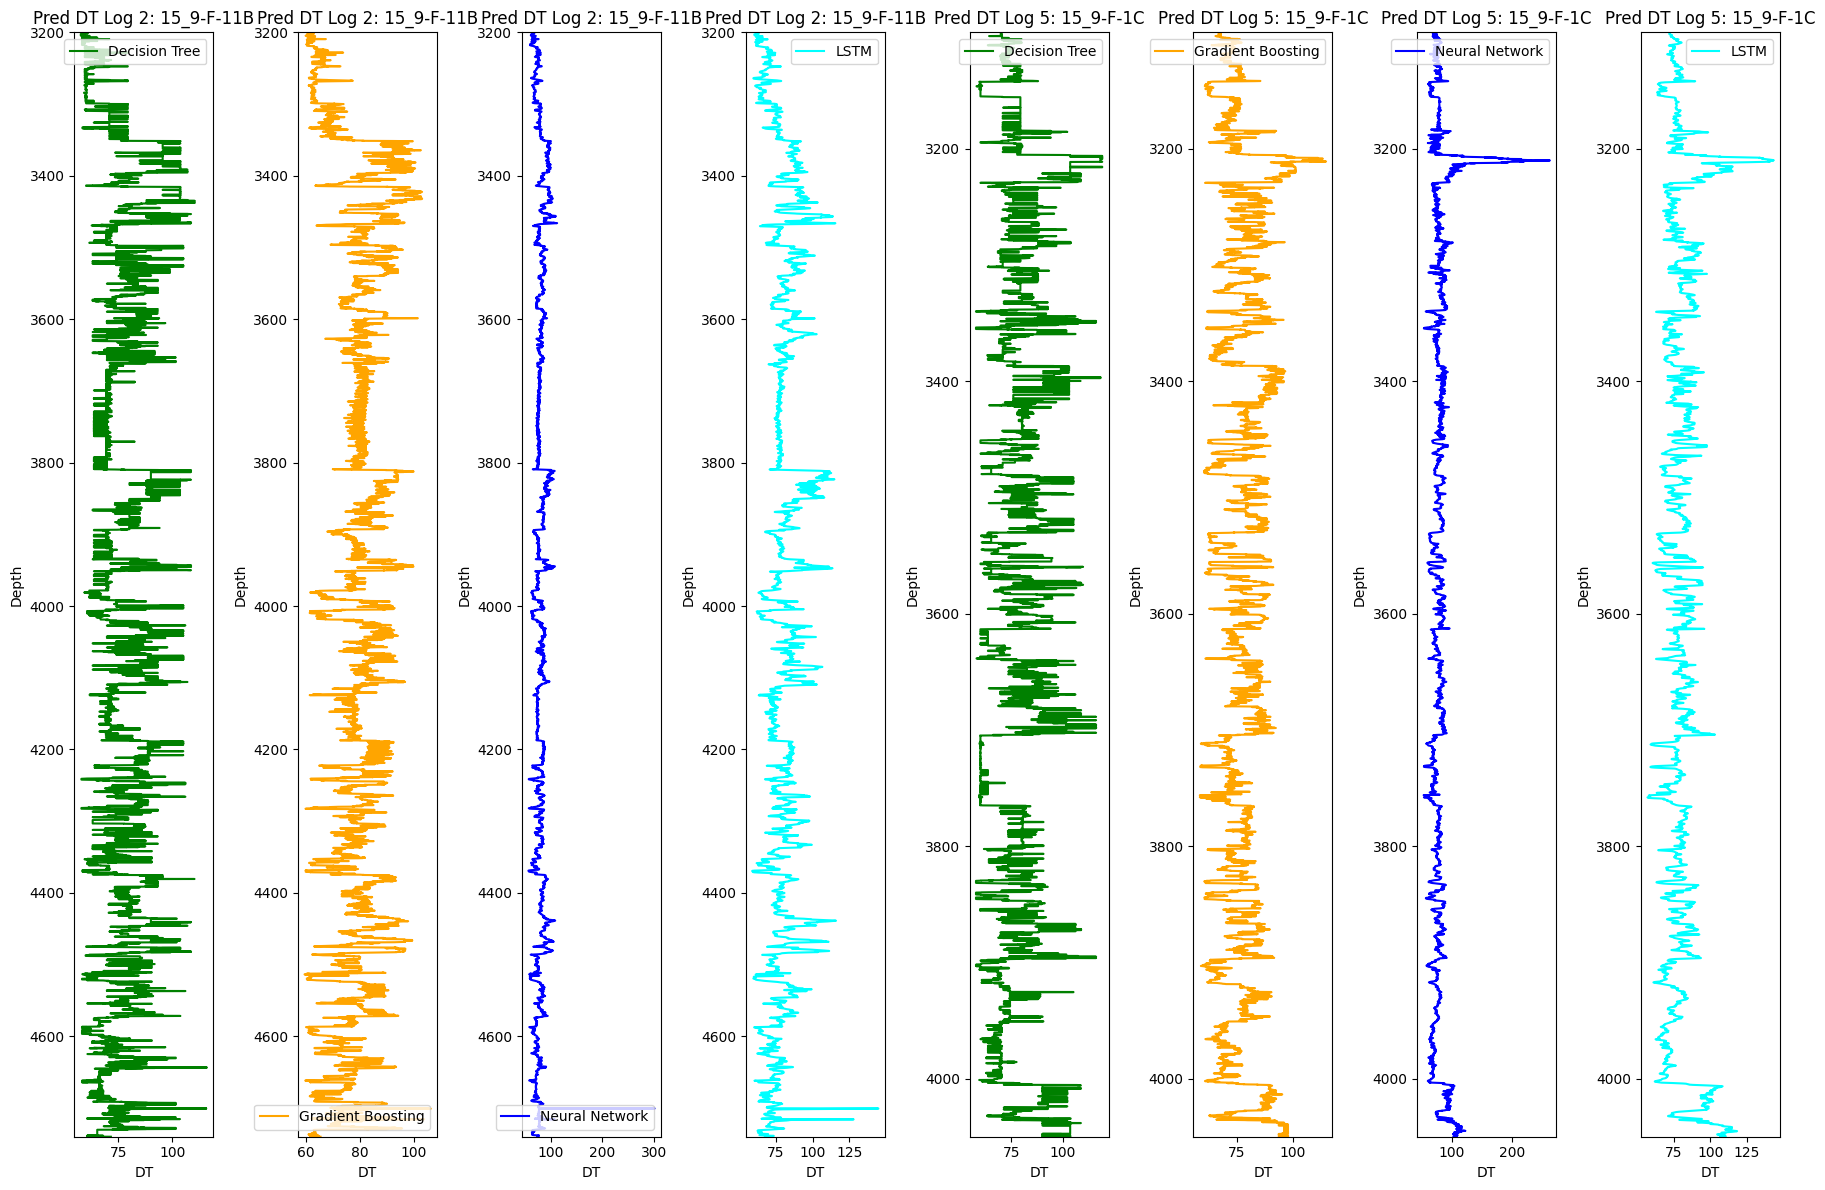

In [110]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='orange', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='blue', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='orange', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='blue', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [111]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

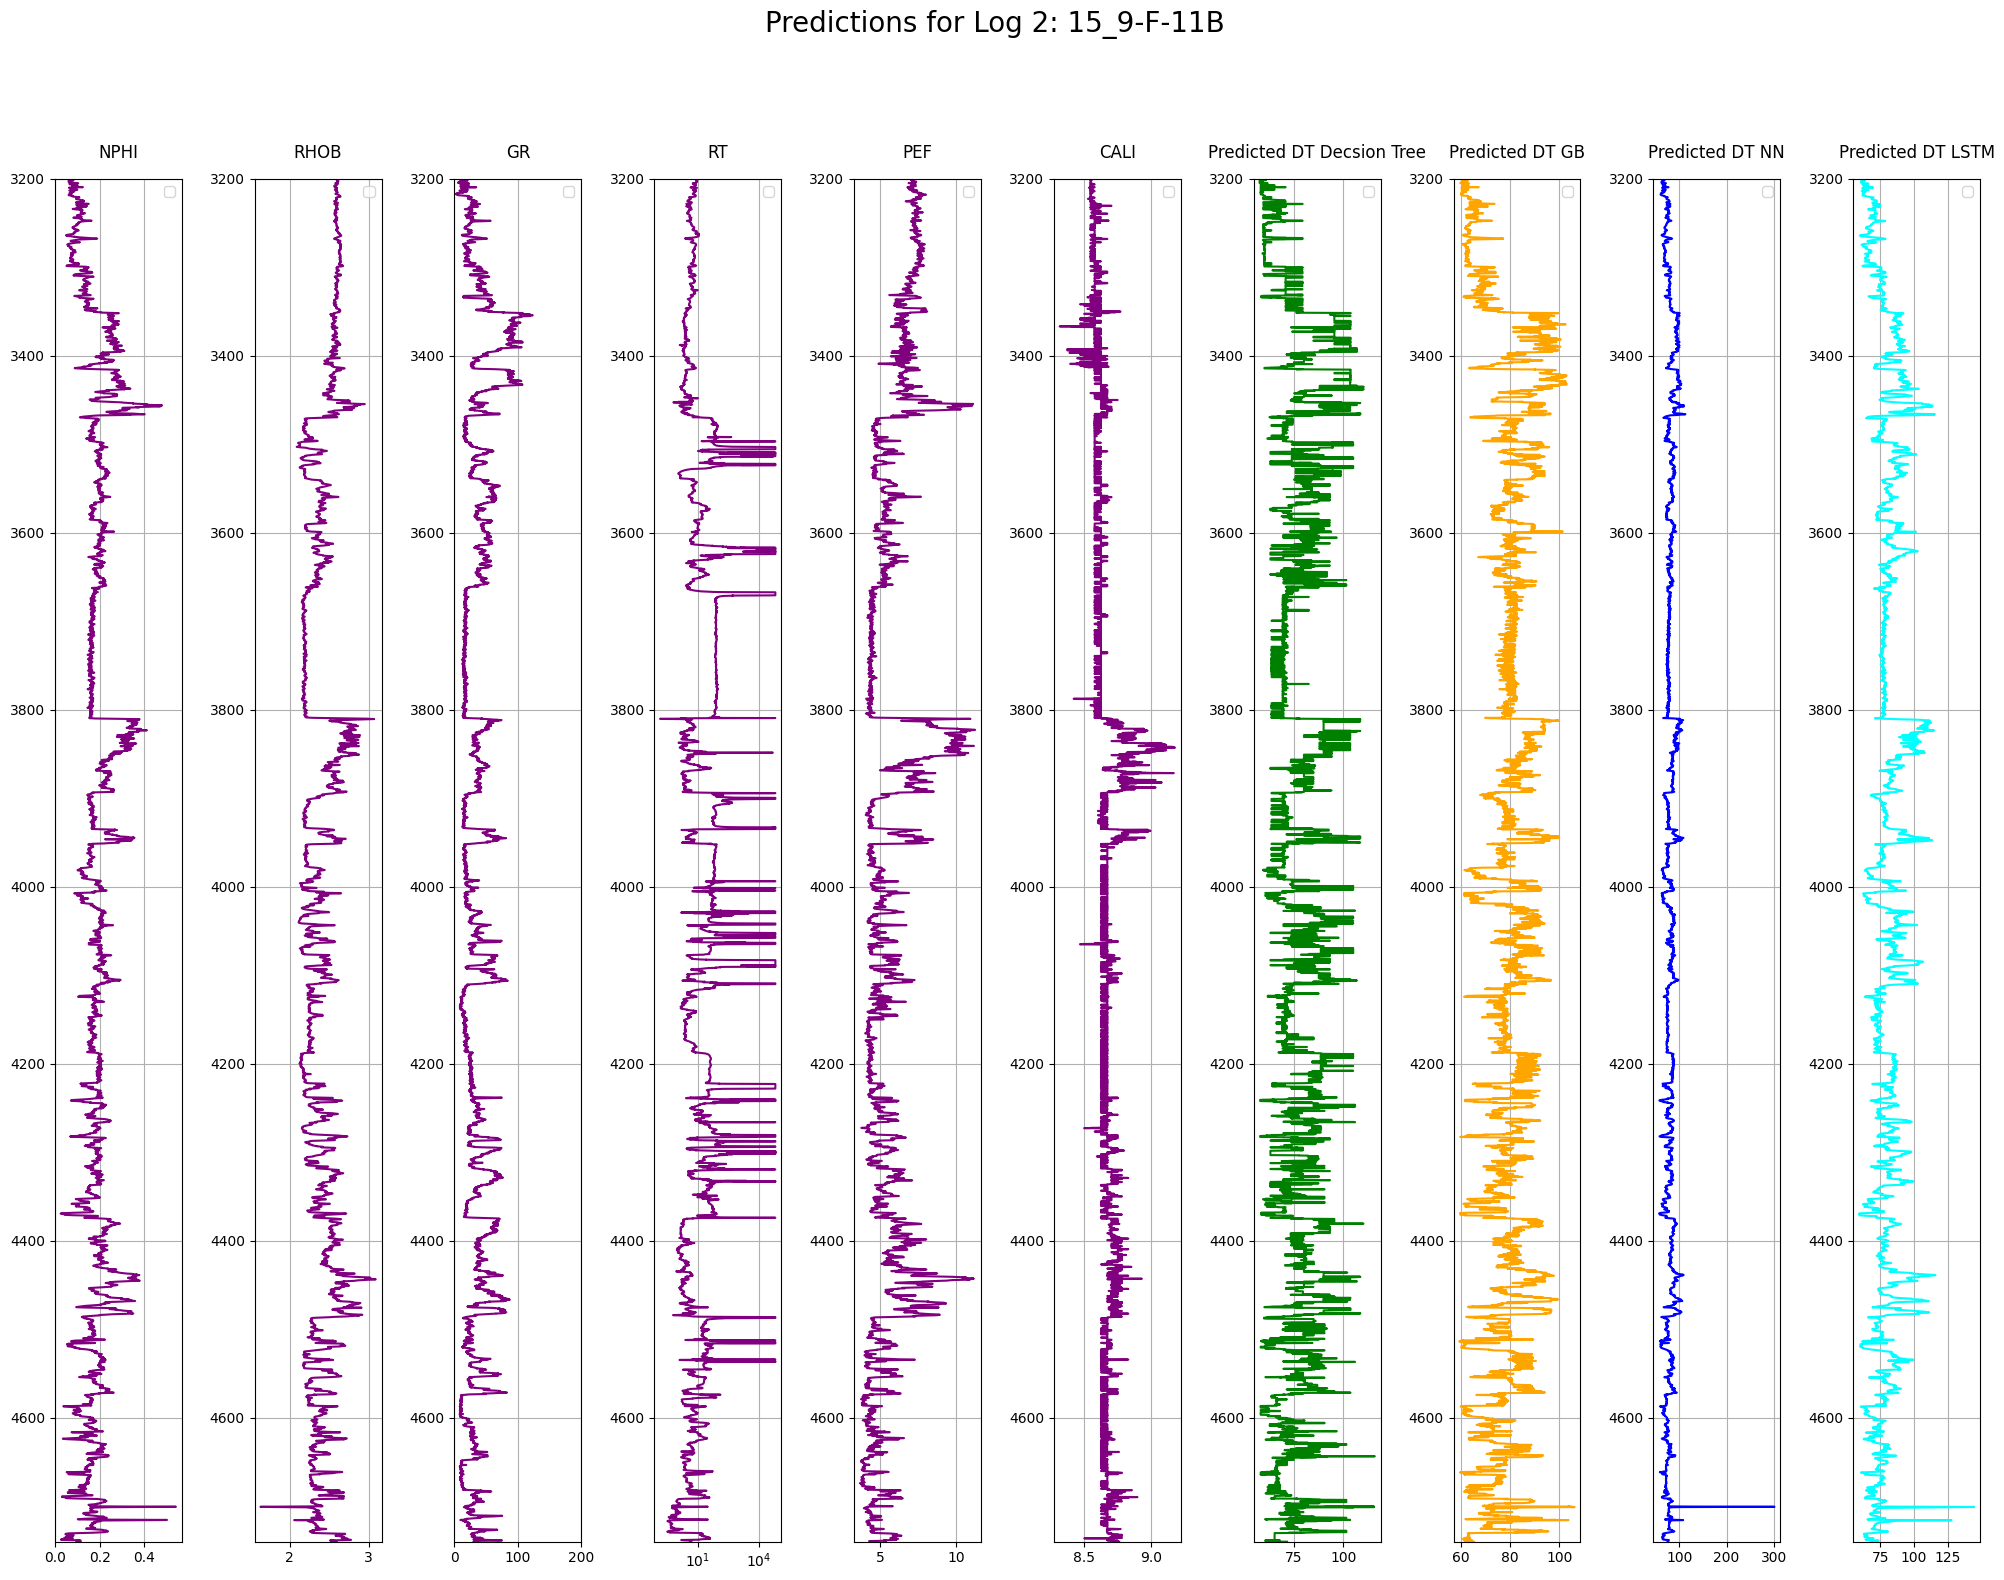

In [112]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

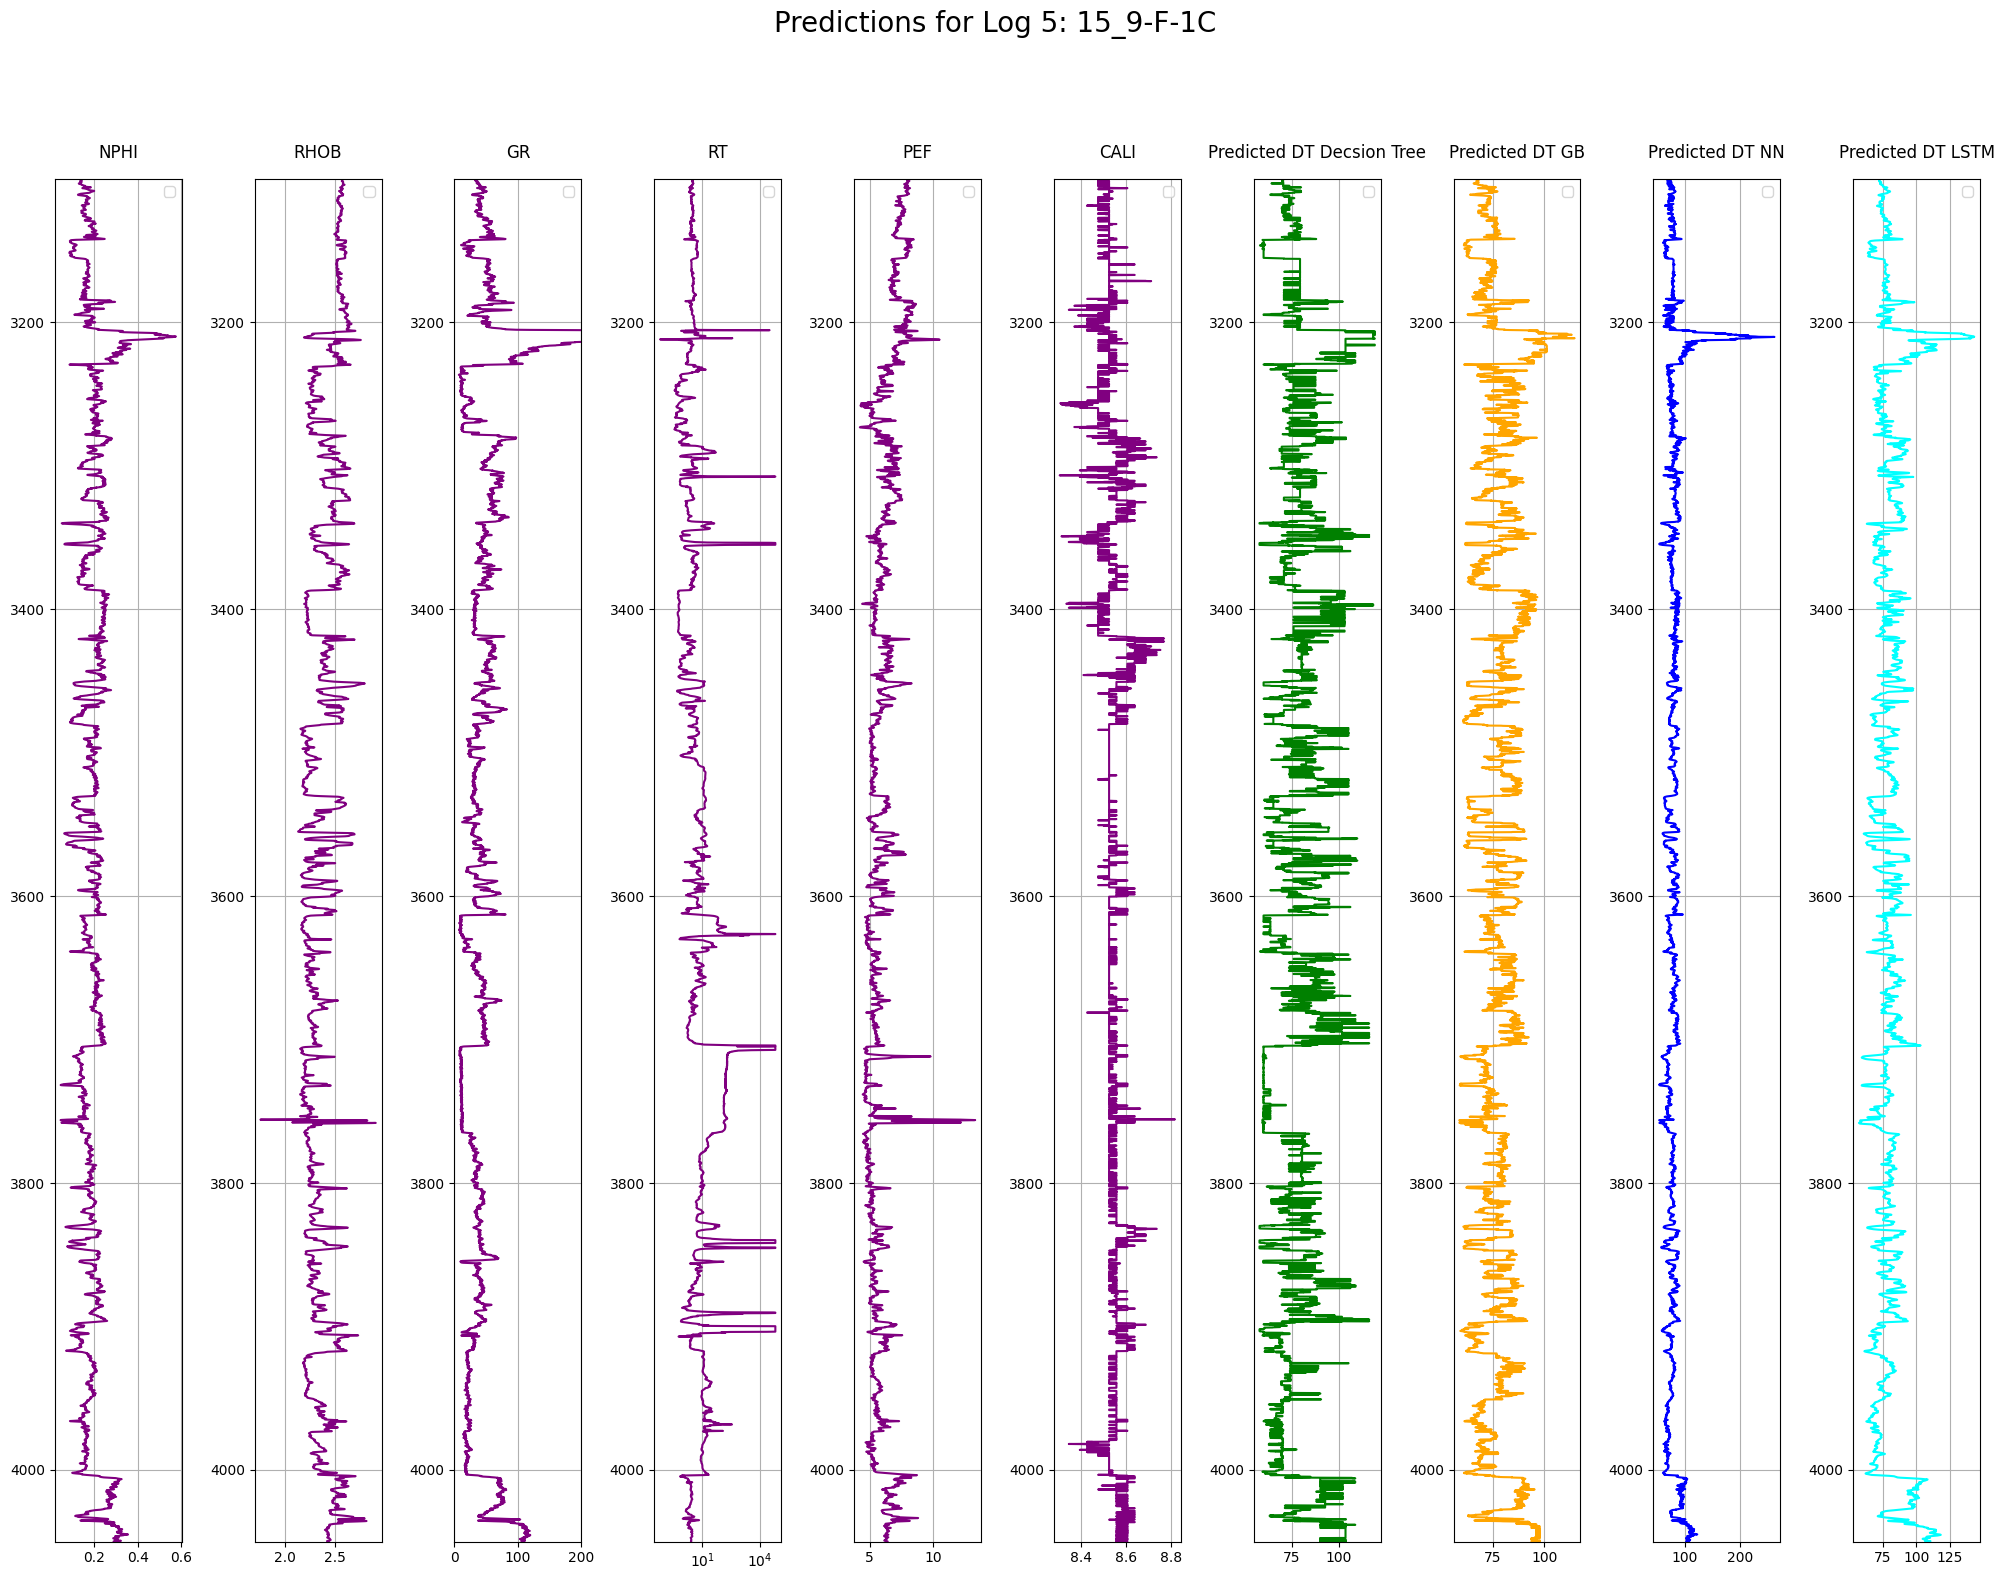

In [113]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")